In [143]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.metric import plot_metric, plot_multiple_metrics
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from utils import get_dict_from_pkl, save_dict_to_pkl

In [145]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

# TODO Remove in final notebook
#param_combinations = param_combinations[:3]

Number of Hyperparameter combinations: 12


In [146]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam_w": torch.optim.AdamW,
        "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        # "step_lr": (StepLR, {"step_size": 2, "gamma": 0.5}),
        "no_scheduler": (None, None),
        "exponential_lr": (ExponentialLR, {"gamma": 0.8}),
    }

    # Setup trainer
    # lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=epochs, args={
    #         "blank_label": blank_label,
    #         "cnn_output_width": cnn_output_width,
    #     })
    # trainers = {
    #     "lstm_cnn": lstm_trainer
    # }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                if scheduler_name == "no_scheduler":
                    scheduler = None
                else:
                    scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]

                # Create model name
                abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
                abbreviation = abbreviation.replace(".", "_")
                main_model_name = model_name.split('-', 1)[0]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_{abbreviation}"

                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                    scheduler=scheduler
                )
                # trainer.to_device("mps")
                trainers[trainer_name] = trainer
    #             break
    #         break
    #     break
    # break

    
print(f"Prepared {len(trainers)} models for training.")

Prepared 144 models for training.


In [147]:
import time

metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    start_time = time.time()
    metrics = trainer.train_validate_test()
    end_time = time.time()
    print(f"Finished training {model_name} and took {end_time - start_time} seconds.")
    print("\n" + 100*"#" + "\n")
    
    # Save the trained model with abbreviation and parameter values
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/'

    # Add metrics to model name
    metrics_global[f"{model_name}"] = metrics
    
    # Save model to disk
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    torch.save(trainer.model.state_dict(), save_path)
    save_dict_to_pkl(metrics_global, "metrics_global")

Training lstm_cnn-adam_w_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 1/10; Loss: 2.5620224475860596; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:06<00:00,  6.75it/s]


Validate Epoch: 1/10; Loss: 2.6249468326568604; Correct: 0/2999 = 0.0000; Average CER Score: 1.0


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 2/10; Loss: 2.492133378982544; Correct: 0/7000 = 0.0000; Average CER Score: 0.999


100%|██████████| 47/47 [00:06<00:00,  6.72it/s]


Validate Epoch: 2/10; Loss: 2.566903591156006; Correct: 0/2999 = 0.0000; Average CER Score: 0.991


100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


Training Epoch: 3/10; Loss: 2.487724781036377; Correct: 0/7000 = 0.0000; Average CER Score: 0.988


100%|██████████| 47/47 [00:07<00:00,  6.66it/s]


Validate Epoch: 3/10; Loss: 2.4083774089813232; Correct: 0/2999 = 0.0000; Average CER Score: 0.973


100%|██████████| 110/110 [00:32<00:00,  3.38it/s]


Training Epoch: 4/10; Loss: 2.1166069507598877; Correct: 0/7000 = 0.0000; Average CER Score: 0.972


100%|██████████| 47/47 [00:07<00:00,  6.69it/s]


Validate Epoch: 4/10; Loss: 2.02249813079834; Correct: 0/2999 = 0.0000; Average CER Score: 0.956


100%|██████████| 110/110 [00:32<00:00,  3.39it/s]


Training Epoch: 5/10; Loss: 1.415188193321228; Correct: 2/7000 = 0.0003; Average CER Score: 0.948


100%|██████████| 47/47 [00:07<00:00,  6.62it/s]


Validate Epoch: 5/10; Loss: 1.4761571884155273; Correct: 18/2999 = 0.0060; Average CER Score: 0.919


100%|██████████| 110/110 [00:32<00:00,  3.36it/s]


Training Epoch: 6/10; Loss: 0.5542123317718506; Correct: 920/7000 = 0.1314; Average CER Score: 0.874


100%|██████████| 47/47 [00:07<00:00,  6.56it/s]


Validate Epoch: 6/10; Loss: 0.6237149238586426; Correct: 1032/2999 = 0.3441; Average CER Score: 0.802


100%|██████████| 110/110 [00:32<00:00,  3.35it/s]


Training Epoch: 7/10; Loss: 0.3694000542163849; Correct: 3505/7000 = 0.5007; Average CER Score: 0.77


100%|██████████| 47/47 [00:07<00:00,  6.60it/s]


Validate Epoch: 7/10; Loss: 0.4141220450401306; Correct: 1774/2999 = 0.5915; Average CER Score: 0.704


100%|██████████| 110/110 [00:32<00:00,  3.37it/s]


Training Epoch: 8/10; Loss: 0.19424861669540405; Correct: 4888/7000 = 0.6983; Average CER Score: 0.684


100%|██████████| 47/47 [00:07<00:00,  6.39it/s]


Validate Epoch: 8/10; Loss: 0.28928443789482117; Correct: 2131/2999 = 0.7106; Average CER Score: 0.625


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 9/10; Loss: 0.17281872034072876; Correct: 5624/7000 = 0.8034; Average CER Score: 0.613


100%|██████████| 47/47 [00:07<00:00,  6.30it/s]


Validate Epoch: 9/10; Loss: 0.18776611983776093; Correct: 2242/2999 = 0.7476; Average CER Score: 0.563


100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Training Epoch: 10/10; Loss: 0.13210564851760864; Correct: 5820/7000 = 0.8314; Average CER Score: 0.556


100%|██████████| 47/47 [00:07<00:00,  6.29it/s]


Validate Epoch: 10/10; Loss: 0.21169792115688324; Correct: 2302/2999 = 0.7676; Average CER Score: 0.512


100%|██████████| 1/1 [00:00<00:00, 153.50it/s]


Test Predictions --> Loss: 0.03896240144968033; Correct: 1/1 = 1.0000; Average CER Score: 0.512
Finished training lstm_cnn-adam_w_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64 and took 401.12872791290283 seconds.

####################################################################################################

Training lstm_cnn-adam_w_no_scheduler_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Training Epoch: 1/10; Loss: 0.09461338073015213; Correct: 6023/7000 = 0.8604; Average CER Score: 0.032


100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Validate Epoch: 1/10; Loss: 0.19511878490447998; Correct: 2333/2999 = 0.7779; Average CER Score: 0.056


100%|██████████| 110/110 [00:33<00:00,  3.25it/s]


Training Epoch: 2/10; Loss: 0.12316945940256119; Correct: 6121/7000 = 0.8744; Average CER Score: 0.03


100%|██████████| 47/47 [00:07<00:00,  6.47it/s]


Validate Epoch: 2/10; Loss: 0.15265624225139618; Correct: 2352/2999 = 0.7843; Average CER Score: 0.056


100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


Training Epoch: 3/10; Loss: 0.0823090597987175; Correct: 6198/7000 = 0.8854; Average CER Score: 0.029


100%|██████████| 47/47 [00:07<00:00,  6.48it/s]


Validate Epoch: 3/10; Loss: 0.1363014578819275; Correct: 2368/2999 = 0.7896; Average CER Score: 0.055


100%|██████████| 110/110 [00:33<00:00,  3.25it/s]


Training Epoch: 4/10; Loss: 0.1262056976556778; Correct: 6251/7000 = 0.8930; Average CER Score: 0.028


100%|██████████| 47/47 [00:07<00:00,  6.54it/s]


Validate Epoch: 4/10; Loss: 0.1527717411518097; Correct: 2402/2999 = 0.8009; Average CER Score: 0.054


  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
# Save and load metrics to file
save_dict_to_pkl(metrics_global, "metrics_global")
grid_search_metrics = get_dict_from_pkl("metrics_global")

In [ ]:
# Get top 5 models based on loss
top_models = {}

def get_top_models(metric="test_loss", top_n=5):

    for model_name, model_scores in grid_search_metrics.items():
        model_metric = model_scores[metric][0]
        top_models[model_name] = model_metric

    # Sort models by loss (ascending order)
    sorted_models = dict(sorted(top_models.items(), key=lambda item: item[1]))

    # Get top 5 models
    top_n_models = dict(list(sorted_models.items())[:top_n])

    # Create a new dictionary with numerical keys
    numerical_top_models = {model: {"id": idx, f"{metric}": metric_value} for idx, (model, metric_value) in enumerate(top_n_models.items())}

    # Print the top 5 models with numerical keys
    for item in numerical_top_models.items():
        print(item)
    return numerical_top_models

# Get top 5 models based on loss
numerical_top_models = get_top_models(metric="test_loss", top_n=5)

('crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64', {'id': 0, 'test_loss': 2.637765884399414})


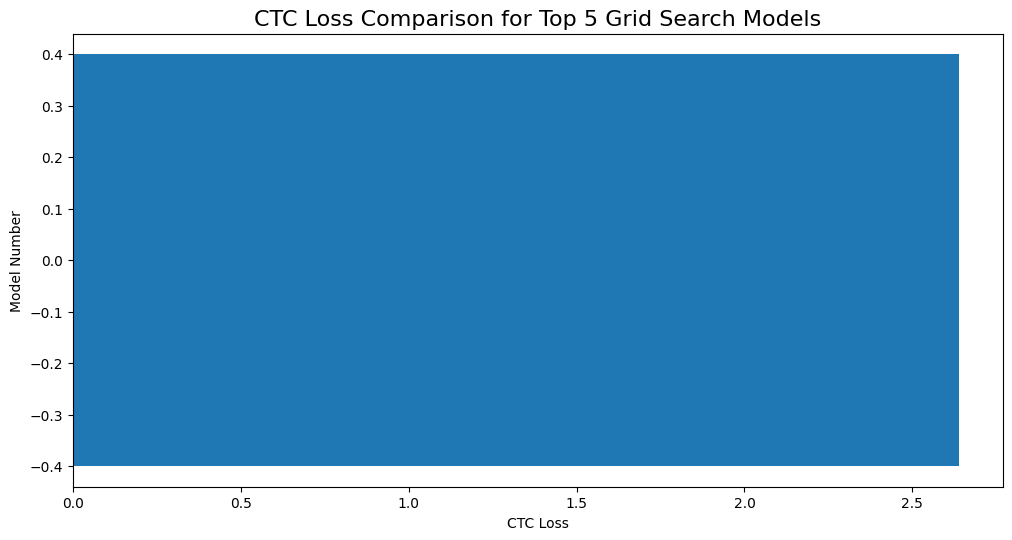

In [ ]:
import numpy as np
from utils import split_and_insert_newline_list 
import matplotlib.pyplot as plt

model_names_top_5 = list(numerical_top_models.keys())
model_number_top_5 = [item["id"] for idx, item in numerical_top_models.items()]
model_scores_top_5 = [item["test_loss"] for idx, item in numerical_top_models.items()]

# Create a horizontal bar plot for all metrics
# Update fig size
plt.figure(figsize=(12, 6), dpi=100)

plt.barh(model_number_top_5, model_scores_top_5)  # Horizontal bar plot

plt.xlabel('CTC Loss')  # Adjust label
plt.ylabel('Model Number')  # Adjust label
plt.title('CTC Loss Comparison for Top 5 Grid Search Models', fontsize=16)  # Adjust title font size

# Customize font size for model names
plt.yticks(fontsize=10)

plt.show()


## Plot CTC loss and CER metric to file

In [ ]:
for model_name, trainer in trainers.items():
    main_model_name = model_name.split('-', 1)[0]
    # Get model paths
    base_path = f'models/{main_model_name}/{model_name}/'
    model_path = base_path + "model.pth"
    
    print(f"Saving Loss Plot for model: {model_name}")
    #model = model.to("mps")
    # model.load_state_dict(torch.load(model_path))

    # Plot the trained model
    plot_metric(model_name=model_name, train_metric_per_epoch=trainer.metrics["train_loss"], val_metric_per_epoch=trainer.metrics["val_loss"], figure_evaluation_dir=f"{base_path}", metric_name="CTC Loss")
    plot_metric(model_name=model_name, train_metric_per_epoch=trainer.metrics["train_cer"], val_metric_per_epoch=trainer.metrics["val_cer"], figure_evaluation_dir=f"{base_path}", metric_name="CER")

Saving Loss Plot for model: crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Plot CTC loss and CER metric to file for top 5 models

In [ ]:
model_ids = []
model_training_losses = []
model_val_losses = []
model_training_cers = []
model_val_cers = []

for model_name, trainer in trainers.items():
    if model_name in model_names_top_5:
        model_id = numerical_top_models[model_name]["id"]
        model_ids.append(model_id)
        # Add best losses to list
        model_training_losses.append(trainer.metrics["train_loss"])
        model_val_losses.append(trainer.metrics["val_loss"])
        # Add cers for best losses to list
        model_training_cers.append(trainer.metrics["train_cer"])
        model_val_cers.append(trainer.metrics["val_cer"])

# Get model paths
main_model_name = model_name.split('-', 1)[0]
base_path = f'models/{main_model_name}/'

# Plot the trained model
plot_multiple_metrics(
    model_names=model_ids, 
    train_metrics_list=model_training_losses, 
    val_metrics_list=model_val_losses, 
    figure_evaluation_dir=base_path,
    metric_name="CTC Loss"
)

plot_multiple_metrics(
    model_names=model_ids, 
    train_metrics_list=model_training_cers, 
    val_metrics_list=model_val_cers, 
    figure_evaluation_dir=base_path,
    metric_name="CER"
)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Testing model crnn-adam_step_lr_G128__L2__H4__W32__LR0_01__BS64__BSV64


100%|██████████| 1/1 [00:00<00:00, 162.54it/s]

Test Predictions --> Loss: 2.637765884399414; Correct: 0/1 = 0.0000; Average CER Score: 1.0
Test Sample: 1
Gold Label: [4 3 8 1 6]
Model Output: []


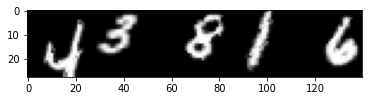


####################################################################################################



In [ ]:
for model_name, trainer in trainers.items():
    print(f"Testing model {model_name}")

    # Plot the trained model
    trainer.test(plot_n=1, plot=True)
    print("\n" + 100*"#" + "\n")